In [29]:
import nltk
import ast
import contractions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models import Word2Vec, KeyedVectors

from nltk.tokenize import word_tokenize, sent_tokenize

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import hamming_loss, f1_score, precision_score, recall_score, accuracy_score

In [2]:
# Make sure tensorflow recognizes my GPU
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Import data
raw_data = pd.read_csv('../../data/parsed_data.csv').fillna('')
raw_data['tags'] = raw_data['tags'].apply(ast.literal_eval)

### Embedding

In [4]:
# Tokenize body text
def tokenize_sentences(text):
    expanded_text = contractions.fix(text)
    sentences = sent_tokenize(expanded_text)
    tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]
    recombined_sentences = []

    # Recombine the tokens that NLTK split (as well as convert them to lowercase)
    for sentence in tokenized_sentences:
        recombined_sentence = []
        skip_counter = 0
        for i, token in enumerate(sentence):
            if skip_counter:
                skip_counter -= 1
                continue
            if token == '<' and i + 2 < len(sentence) and sentence[i + 2] == '>':
                recombined_sentence.append('<' + sentence[i + 1] + '>')
                skip_counter = 2
            else:
                recombined_sentence.append(token.lower())
        recombined_sentences.append(recombined_sentence)
    return recombined_sentences
raw_data['tokenized_body_text'] = raw_data['body_text'].apply(tokenize_sentences)

In [22]:
# Train Word2Vec on text data
tokenized_sentences = [sentence for sentences in raw_data['tokenized_body_text'] for sentence in sentences]

word2vec_model_100 = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4, epochs=10)
word2vec_model_100.save("embeddings/custom_word2vec_100.model")

word2vec_model_300 = Word2Vec(sentences=tokenized_sentences, vector_size=300, window=5, min_count=1, workers=4, epochs=10)
word2vec_model_300.save("embeddings/custom_word2vec_300.model")

In [5]:
word2vec_model_100 = Word2Vec.load('embeddings/custom_word2vec_100.model')
word2vec_model_300 = Word2Vec.load('embeddings/custom_word2vec_300.model')

### Data Prep

In [6]:
# Get rid of all tags I didn't intentionally scrape
rel_tags = [
    'real-analysis',
    'calculus',
    'linear-algebra',
    'probability',
    'abstract-algebra',
    'integration',
    'sequences-and-series',
    'combinatorics',
    'general-topology',
    'matrices',
    'functional-analysis',
    'complex-analysis',
    'geometry',
    'group-theory',
    'algebra-precalculus',
    'probability-theory',
    'ordinary-differential-equations',
    'limits',
    'analysis',
    'number-theory',
    'measure-theory',
    'statistics',
    'multivariable-calculus',
    'functions',
    'derivatives',
    'differential-geometry',
    'discrete-mathematics',
    'trigonometry',
    'algebraic-geometry',
    'elementary-set-theory'
]
raw_data['tags'] = raw_data['tags'].apply(lambda x: [tag for tag in x if tag in rel_tags])

In [7]:
# Data prep
tokenized_texts = [sum(question, []) for question in raw_data['tokenized_body_text'].tolist()]
labels = raw_data['tags'].tolist()

# Create word-to-index mapping
word_index = {}
index = 1
for question in tokenized_texts:
    for token in question:
        if token not in word_index:
            word_index[token] = index
            index += 1

# Convert tokens to sequences of integers
sequences = [[word_index[token] for token in question] for question in tokenized_texts]

# Define maximum sequence length
MAX_SEQ_LEN = 500

# Pad sequences
data = pad_sequences(sequences, maxlen=MAX_SEQ_LEN)

# Encode labels
mlb = MultiLabelBinarizer()
categorical_labels = mlb.fit_transform(labels)

# Check the shapes
print(f'Shape of data tensor: {data.shape}')
print(f'Shape of label tensor: {categorical_labels.shape}')

Shape of data tensor: (235312, 500)
Shape of label tensor: (235312, 30)


In [8]:
# Split the data into train (80%), validation (10%), and test (10%)
data_train, data_temp, labels_train, labels_temp = train_test_split(data, categorical_labels, test_size=0.2, random_state=42)
data_val, data_test, labels_val, labels_test = train_test_split(data_temp, labels_temp, test_size=0.5, random_state=42)

# Check the shapes
print(f'Training data shape: {data_train.shape}')
print(f'Validation data shape: {data_val.shape}')
print(f'Test data shape: {data_test.shape}')

Training data shape: (188249, 500)
Validation data shape: (23531, 500)
Test data shape: (23532, 500)


### Baseline Model

In [9]:
# Create embedding matrix
embedding_dim = word2vec_model_300.vector_size
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if word in word2vec_model_300.wv:
        embedding_matrix[i] = word2vec_model_300.wv[word]

In [10]:
# Custom metric
def micro_precision(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.round(y_pred)
    y_pred = tf.cast(y_pred, tf.float32)
    
    true_positives = K.sum(K.cast(y_true * y_pred, 'float'))
    predicted_positives = K.sum(K.cast(y_pred, 'float'))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [11]:
def micro_f1_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.round(y_pred)
    y_pred = tf.cast(y_pred, tf.float32)
    
    tp = K.sum(K.cast(y_true * y_pred, 'float'))
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'))
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'))
    
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1

In [25]:
def test_model(model, y_true):
    # Test
    predictions = model.predict(data_val)
    predictions = np.round(predictions)
    
    # Calculate metrics
    hamming = hamming_loss(y_true, predictions)
    f1 = f1_score(y_true, predictions, average='micro')
    precision = precision_score(y_true, predictions, average='micro')
    recall = recall_score(y_true, predictions, average='micro')
    subset_acc = accuracy_score(y_true, predictions)
    
    # Print results
    print(f'Hamming Loss: {hamming}')
    print(f'F1 Score: {f1}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'Subset Accuracy: {subset_acc}')

    # Return dictionary with results
    results = {'hamming':hamming, 'f1':f1, 'precision':precision, 'recall':recall, 'subset_acc':subset_acc}
    return results

In [29]:
# Build base model
base_custom_model = Sequential()
base_custom_model.add(Embedding(input_dim = len(word_index) + 1,
                    output_dim = 300,
                    weights=[embedding_matrix],
                    trainable=True))
base_custom_model.add(LSTM(units=128, return_sequences=False))
base_custom_model.add(Dense(len(mlb.classes_), activation='sigmoid'))


# Compile the model
base_custom_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[micro_precision, micro_f1_score])

# Create callback to store intermediate models
checkpoint_callback = ModelCheckpoint(
    filepath='weights/base_custom_embedding/model_epoch_{epoch:02d}.weights.h5',
    save_weights_only=True,
    save_best_only=False,
    save_freq='epoch'  # Save every epoch
)

# Train the model
with tf.device('/GPU:0'):
    base_custom_history = base_custom_model.fit(data_train, labels_train, epochs=4, batch_size=128, validation_data=(data_val, labels_val), callbacks=[checkpoint_callback])

Epoch 1/4
1471/1471 [==============================] - 94s 63ms/step - loss: 0.1362 - micro_precision: 0.5651 - micro_f1_score: 0.3251 - val_loss: 0.1034 - val_micro_precision: 0.7502 - val_micro_f1_score: 0.5451
Epoch 2/4
1471/1471 [==============================] - 90s 61ms/step - loss: 0.0981 - micro_precision: 0.7568 - micro_f1_score: 0.5786 - val_loss: 0.0974 - val_micro_precision: 0.7529 - val_micro_f1_score: 0.5845
Epoch 3/4
1471/1471 [==============================] - 90s 61ms/step - loss: 0.0920 - micro_precision: 0.7645 - micro_f1_score: 0.6107 - val_loss: 0.0952 - val_micro_precision: 0.7476 - val_micro_f1_score: 0.6023
Epoch 4/4
1471/1471 [==============================] - 90s 61ms/step - loss: 0.0866 - micro_precision: 0.7763 - micro_f1_score: 0.6375 - val_loss: 0.0950 - val_micro_precision: 0.7483 - val_micro_f1_score: 0.6049


In [30]:
base_custom_results = test_model(base_custom_model, labels_val)

736/736 [==============================] - 8s 11ms/step
Hamming Loss: 0.034163443967532195
F1 Score: 0.6050084347413073
Precision: 0.7483186127542338
Recall: 0.507766323024055
Subset Accuracy: 0.3714249288173048


In [16]:
# Google news embedding matrix
path = 'embeddings/GoogleNews-vectors-negative300.bin'
google_word2vec_model = KeyedVectors.load_word2vec_format(path, binary=True)

embedding_dim = google_word2vec_model.vector_size
google_embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if word in google_word2vec_model:
        google_embedding_matrix[i] = google_word2vec_model[word]

In [19]:
# Build base model
base_google_model = Sequential()
base_google_model.add(Embedding(input_dim = len(word_index) + 1,
                    output_dim = 300,
                    weights=[google_embedding_matrix],
                    trainable=True))
base_google_model.add(LSTM(units=128, return_sequences=False))
base_google_model.add(Dense(len(mlb.classes_), activation='sigmoid'))

# Compile the model
base_google_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[micro_precision, micro_f1_score])

# Create callback to store intermediate models
checkpoint_callback = ModelCheckpoint(
    filepath='weights/base_google_embedding/model_epoch_{epoch:02d}.weights.h5',
    save_weights_only=True,
    save_best_only=False,
    save_freq='epoch'  # Save every epoch
)

# Train the model
google_history = base_google_model.fit(data_train, labels_train, epochs=4, batch_size=128, validation_data=(data_val, labels_val), callbacks=[checkpoint_callback])

Epoch 1/4
1471/1471 [==============================] - 95s 64ms/step - loss: 0.1974 - micro_precision: 3.5655e-04 - micro_f1_score: 4.0793e-04 - val_loss: 0.1671 - val_micro_precision: 0.0054 - val_micro_f1_score: 5.2510e-05
Epoch 2/4
1471/1471 [==============================] - 93s 63ms/step - loss: 0.1283 - micro_precision: 0.6637 - micro_f1_score: 0.3151 - val_loss: 0.1113 - val_micro_precision: 0.7429 - val_micro_f1_score: 0.5015
Epoch 3/4
1471/1471 [==============================] - 92s 62ms/step - loss: 0.1010 - micro_precision: 0.7570 - micro_f1_score: 0.5662 - val_loss: 0.1001 - val_micro_precision: 0.7564 - val_micro_f1_score: 0.5791
Epoch 4/4
1471/1471 [==============================] - 90s 61ms/step - loss: 0.0913 - micro_precision: 0.7703 - micro_f1_score: 0.6203 - val_loss: 0.0981 - val_micro_precision: 0.7343 - val_micro_f1_score: 0.6022


In [21]:
base_google_results = test_model(base_google_model, labels_val)

736/736 [==============================] - 8s 11ms/step
Hamming Loss: 0.03473007238678056
F1 Score: 0.602454962624248
Precision: 0.7343848829854522
Recall: 0.5107079037800687
Subset Accuracy: 0.37176490586885386


### Expanded Model and Hyperparameter Tuning

Here, I'm going to add an extra LSTM layer as well as two dropout layers for regularization. From here, I'll adjust hyperparameters. I'll be using the custom embedding matrix as initial weights since they seemed to perform slightly better.

In [13]:
# Function to create arbitrary model
def create_model(lstm_units, dropout_rate, learning_rate):
    model = Sequential()
    model.add(Embedding(input_dim=len(word_index) + 1,
                        output_dim=300,
                        weights=[embedding_matrix],
                        trainable=False))
    model.add(LSTM(units=lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=lstm_units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(len(mlb.classes_), activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[micro_precision, micro_f1_score])
    return model

In [14]:
# Define a grid of hyperparameters to search
batch_sizes = [32, 64, 128]
lstm_units = [64, 128, 256]
dropout_rates = [0.3, 0.5, 0.7]
learning_rates = [1e-3, 1e-4]

best_val_f1 = 0
best_hyperparams = {}

for batch_size in batch_sizes:
    for units in lstm_units:
        for dropout_rate in dropout_rates:
            for learning_rate in learning_rates:
                print(f'Training with batch_size={batch_size}, lstm_units={units}, dropout_rate={dropout_rate}, learning_rate={learning_rate}')
                model = create_model(units, dropout_rate, learning_rate)
                
                # Define callbacks
                checkpoint_callback = ModelCheckpoint(
                    filepath=f'weights/hyperparams/expanded_model_bs{batch_size}_units{units}_dr{dropout_rate}_lr{learning_rate}_epoch{{epoch:02d}}.weights.h5',
                    save_weights_only=True,
                    save_best_only=True,
                    monitor='val_micro_f1_score',
                    mode='min',
                    save_freq='epoch'
                )

                early_stopping = EarlyStopping(monitor='val_micro_f1_score', patience=3, restore_best_weights=True)

                history = model.fit(
                    data_train, labels_train,
                    epochs=10,
                    batch_size=batch_size,
                    validation_data=(data_val, labels_val),
                    callbacks=[checkpoint_callback, early_stopping]
                )

                val_f1 = max(history.history['val_micro_f1_score'])
                if val_f1 > best_val_f1:
                    best_val_f1 = val_f1
                    best_hyperparams = {
                        'batch_size': batch_size,
                        'lstm_units': units,
                        'dropout_rate': dropout_rate,
                        'learning_rate': learning_rate
                    }
                tf.keras.backend.clear_session()
                print(f'Best val_f1 so far: {best_val_f1} with hyperparams: {best_hyperparams}')

print(f'Best hyperparameters: {best_hyperparams}')

Training with batch_size=32, lstm_units=64, dropout_rate=0.3, learning_rate=0.001
Epoch 1/10
5883/5883 [==============================] - 232s 38ms/step - loss: 0.1448 - micro_precision: 0.5380 - micro_f1_score: 0.2622 - val_loss: 0.1075 - val_micro_precision: 0.7595 - val_micro_f1_score: 0.5015
Epoch 2/10
5883/5883 [==============================] - 225s 38ms/step - loss: 0.1082 - micro_precision: 0.7413 - micro_f1_score: 0.5211 - val_loss: 0.0991 - val_micro_precision: 0.7691 - val_micro_f1_score: 0.5596
Epoch 3/10
5883/5883 [==============================] - 230s 39ms/step - loss: 0.1026 - micro_precision: 0.7550 - micro_f1_score: 0.5583 - val_loss: 0.0964 - val_micro_precision: 0.7760 - val_micro_f1_score: 0.5732
Epoch 4/10
5883/5883 [==============================] - 229s 39ms/step - loss: 0.0998 - micro_precision: 0.7594 - micro_f1_score: 0.5747 - val_loss: 0.0949 - val_micro_precision: 0.7702 - val_micro_f1_score: 0.5868
Best val_f1 so far: 0.5867583155632019 with hyperparams: {

### Final Model

In [21]:
final_model = create_model(256, 0.3, 0.001)

checkpoint_callback = ModelCheckpoint(
    filepath='weights/final_model/final_model_epoch_{epoch:02d}.weights.h5',
    save_weights_only=True,
    save_best_only=False,
    save_freq='epoch'  # Save every epoch
)

history = final_model.fit(
                np.concatenate([data_train, data_val]), np.concatenate([labels_train, labels_val]),
                epochs=25,
                batch_size=64,
                callbacks=[checkpoint_callback]
            )

Epoch 1/25
3310/3310 [==============================] - 700s 211ms/step - loss: 0.1297 - micro_precision: 0.5995 - micro_f1_score: 0.3757
Epoch 2/25
3310/3310 [==============================] - 866s 262ms/step - loss: 0.0992 - micro_precision: 0.7453 - micro_f1_score: 0.5778
Epoch 3/25
3310/3310 [==============================] - 573s 173ms/step - loss: 0.0936 - micro_precision: 0.7565 - micro_f1_score: 0.6062
Epoch 4/25
3310/3310 [==============================] - 525s 159ms/step - loss: 0.0904 - micro_precision: 0.7630 - micro_f1_score: 0.6221
Epoch 5/25
3310/3310 [==============================] - 498s 150ms/step - loss: 0.0880 - micro_precision: 0.7675 - micro_f1_score: 0.6328
Epoch 6/25
3310/3310 [==============================] - 1003s 303ms/step - loss: 0.0862 - micro_precision: 0.7717 - micro_f1_score: 0.6419
Epoch 7/25
3310/3310 [==============================] - 494s 149ms/step - loss: 0.0843 - micro_precision: 0.7758 - micro_f1_score: 0.6495
Epoch 8/25
3310/3310 [===========

In [23]:
predictions = final_model.predict(data_test)
predictions = np.round(predictions)

# Calculate metrics
hamming = hamming_loss(labels_test, predictions)
f1 = f1_score(labels_test, predictions, average='micro')
precision = precision_score(labels_test, predictions, average='micro')
recall = recall_score(labels_test, predictions, average='micro')
subset_acc = accuracy_score(labels_test, predictions)

# Print results
print(f'Hamming Loss: {hamming}')
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Subset Accuracy: {subset_acc}')

736/736 [==============================] - 89s 120ms/step
Hamming Loss: 0.03299620375092073
F1 Score: 0.6400024727227769
Precision: 0.7268578649910485
Recall: 0.571688892570198
Subset Accuracy: 0.41199218086010536


### Figs

In [26]:
# Baseline custom embedding performance
base_custom_model = Sequential()
base_custom_model.add(Embedding(input_dim = len(word_index) + 1,
                    output_dim = 300,
                    weights=[embedding_matrix],
                    trainable=True))
base_custom_model.add(LSTM(units=128, return_sequences=False))
base_custom_model.add(Dense(len(mlb.classes_), activation='sigmoid'))

base_custom_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[micro_precision, micro_f1_score])

base_custom_model.load_weights('weights/base_custom_embedding/model_epoch_04.weights.h5')

base_custom_results = test_model(base_custom_model, labels_val)

736/736 [==============================] - 8s 11ms/step
Hamming Loss: 0.034163443967532195
F1 Score: 0.6050084347413073
Precision: 0.7483186127542338
Recall: 0.507766323024055
Subset Accuracy: 0.3714249288173048


In [27]:
# Baseline google embedding performance
base_google_model = Sequential()
base_google_model.add(Embedding(input_dim = len(word_index) + 1,
                    output_dim = 300,
                    weights=[google_embedding_matrix],
                    trainable=True))
base_google_model.add(LSTM(units=128, return_sequences=False))
base_google_model.add(Dense(len(mlb.classes_), activation='sigmoid'))

# Compile the model
base_google_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[micro_precision, micro_f1_score])

base_google_model.load_weights('weights/base_google_embedding/model_epoch_04.weights.h5')

base_google_results = test_model(base_google_model, labels_val)

736/736 [==============================] - 8s 10ms/step
Hamming Loss: 0.03473007238678056
F1 Score: 0.602454962624248
Precision: 0.7343848829854522
Recall: 0.5107079037800687
Subset Accuracy: 0.37176490586885386


In [19]:
# Final model performance
final_model = create_model(256, 0.3, 0.001)
final_model.load_weights('weights/final_model/final_model_epoch_25.weights.h5')

In [21]:
# Test
predictions = final_model.predict(data_test)
predictions = np.round(predictions)

# Calculate metrics
hamming = hamming_loss(labels_test, predictions)
f1 = f1_score(labels_test, predictions, average='micro')
precision = precision_score(labels_test, predictions, average='micro')
recall = recall_score(labels_test, predictions, average='micro')
subset_acc = accuracy_score(labels_test, predictions)

# Print results
print(f'Hamming Loss: {hamming}')
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Subset Accuracy: {subset_acc}')

final_results = {'hamming':hamming, 'f1':f1, 'precision':precision, 'recall':recall, 'subset_acc':subset_acc}

736/736 [==============================] - 17s 23ms/step
Hamming Loss: 0.03299620375092073
F1 Score: 0.6400024727227769
Precision: 0.7268578649910485
Recall: 0.571688892570198
Subset Accuracy: 0.41199218086010536


C:\Users\joetn\AppData\Local\Temp\ipykernel_20784\314804146.py:16: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  ax = sns.barplot(x='Metric', y='value', hue='Model', data=pd.melt(df[df['Metric'] != 'Hamming Loss'], id_vars='Metric', var_name='Model', value_name='value'), palette=palette)
C:\Users\joetn\AppData\Local\Temp\ipykernel_20784\314804146.py:22: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  ax2 = sns.barplot(x='Metric', y='value', hue='Model', data=pd.melt(df[df['Metric'] == 'Hamming Loss'], id_vars='Metric', var_name='Model', value_name='value'), ax=ax2, dodge=True, palette=palette)


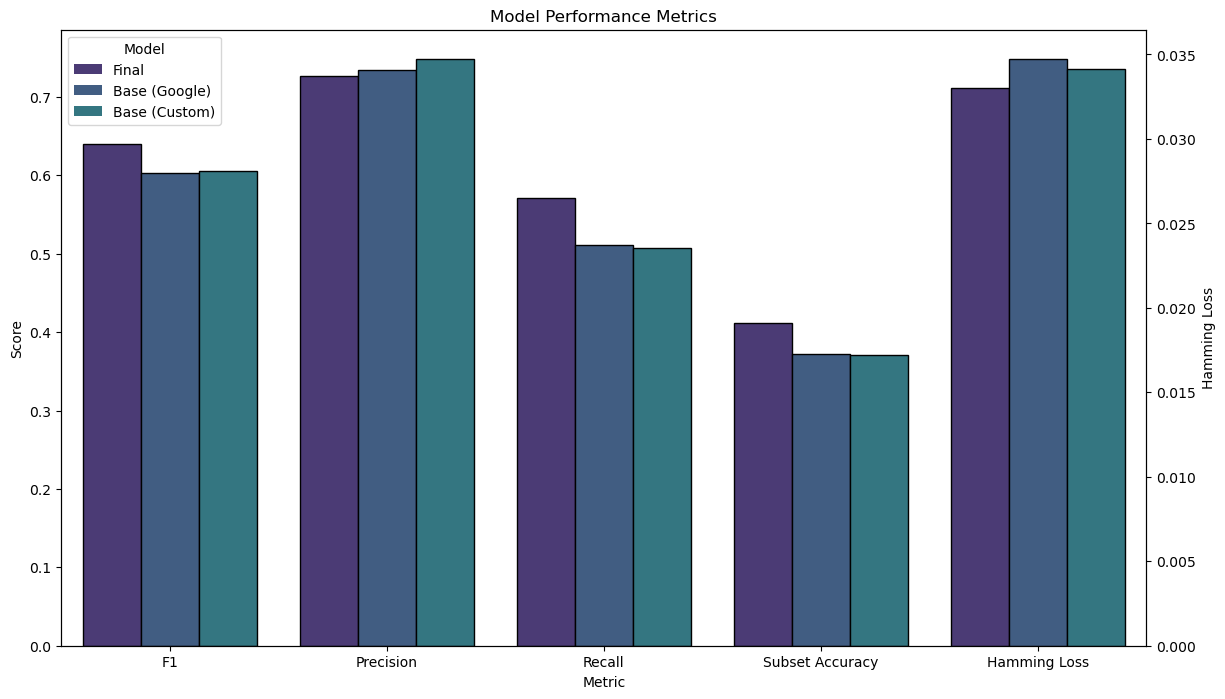

In [49]:
# Graph results
data = {
    'Metric': ['Hamming Loss', 'F1', 'Precision', 'Recall', 'Subset Accuracy'],
    'Final': [final_results['hamming'], final_results['f1'], final_results['precision'], final_results['recall'], final_results['subset_acc']],
    'Base (Google)': [base_google_results['hamming'], base_google_results['f1'], base_google_results['precision'], base_google_results['recall'], base_google_results['subset_acc']],
    'Base (Custom)': [base_custom_results['hamming'], base_custom_results['f1'], base_custom_results['precision'], base_custom_results['recall'], base_custom_results['subset_acc']]
}

df = pd.DataFrame(data)

# Set the figure size and color palette
plt.figure(figsize=(14, 8))
palette = sns.color_palette("viridis")

# Create the first bar plot for f1, precision, recall, and subset_acc
ax = sns.barplot(x='Metric', y='value', hue='Model', data=pd.melt(df[df['Metric'] != 'Hamming Loss'], id_vars='Metric', var_name='Model', value_name='value'), palette=palette)
ax.set_ylabel('Score')
ax.set_title('Model Performance Metrics')

# Create a secondary y-axis for the hamming loss
ax2 = ax.twinx()
ax2 = sns.barplot(x='Metric', y='value', hue='Model', data=pd.melt(df[df['Metric'] == 'Hamming Loss'], id_vars='Metric', var_name='Model', value_name='value'), ax=ax2, dodge=True, palette=palette)
ax2.set_ylabel('Hamming Loss')

# Remove extra legend
ax.legend_.remove()

# Add outline to bars
for patch in ax.patches:
    patch.set_edgecolor('black')
    patch.set_linewidth(1)
for patch in ax2.patches:
    patch.set_edgecolor('black')
    patch.set_linewidth(1)

# Show the plot
plt.savefig('../../figs/recurrent_nn/final_performance.png')
plt.show()